In [ ]:
from Model import Levels, ElectronsTransitionsData, AtomsTransitionsData, Pick, UFloat, utilities
import numpy as np
import pandas as pd
from Model.utilities import n_, s_
from tqdm.auto import tqdm
from PlotUtils.saveToCsv import saveToCsv, getNextFilename

from PlotUtils import errsPlot as plt, splt

splt.set_export_folder(".")

In [28]:
n_g = 2.687e25
T_g = 300

real_value = {
    'T_e' : 2,
    'f_e' : 10**-5
}

In [29]:
data = pd.read_csv('exports/SimulatedData.csv', index_col = False).to_dict('list')

data['density'] = [ UFloat.UFloat( n, s ) for n, s in zip( data['density_n'], data['density_s'] ) ]
data['label_idx'] = Levels.Levels().namesToIdxs( data['label'] )

In [30]:
# Loading data from a previous broad characterization
filename = 'results/r003'

prev = pd.read_csv( filename + '.csv', index_col = False )

f_es = np.unique( prev['f_es'].to_numpy() )
T_es = np.unique( prev['T_es'].to_numpy() )
chisquared = prev['chisquared'].to_numpy().reshape( ( len( f_es ), len( T_es ) ) )

In [31]:
# Spot the interesting area as above 85% of the chi squared
chisquared_f_e = np.min( chisquared, axis = 1 )
chisquared_T_e = np.min( chisquared, axis = 0 )

chisquared_f_e_idx = np.where( 1 / chisquared_f_e > 1 / np.min( chisquared_f_e ) * 0.75 )
chisquared_T_e_idx = np.where( 1 / chisquared_T_e > 1 / np.min( chisquared_T_e ) * 0.75 )

In [32]:
# Consequently, define the scanning range in the interesting area
f_es = np.linspace( f_es[ np.min( chisquared_f_e_idx ) - 1 ], f_es[ np.max( chisquared_f_e_idx ) + 1 ], 100 )
T_es = np.linspace( T_es[ np.min( chisquared_T_e_idx ) - 1 ], T_es[ np.max( chisquared_T_e_idx ) + 1 ], 100 )

In [ ]:
reps = 150
chisquared = np.zeros( ( len( f_es ), len( T_es ), reps ) )


for k in tqdm( range( reps ), total = reps ):
    pas = Pick.Pick()
    for i, f_e in enumerate( f_es ):
        for j, T_e in enumerate( T_es ):
            chisquared[ i, j, k ] = pas.chiSquared_frompars( data['density'], data['label_idx'], n_g, f_e, T_e, T_g )

chisquared_avg = np.mean( chisquared, axis = 2 )

  0%|          | 0/150 [00:00<?, ?it/s]

In [34]:
f_esm, T_esm = np.meshgrid( f_es, T_es )
data_tosave =  { 'f_es': f_esm.flatten(), 'T_es': T_esm.flatten(), 'chisquared_avg': chisquared_avg.flatten() }
for k in range( chisquared.shape[-1] ):
    data_tosave[ f"chisquared_{k:03d}" ] = chisquared[ :, :, k ].flatten()
filename = saveToCsv( data_tosave, basename = filename + "_r" )

Saved as results/r003_r002


In [35]:
f_e_min_idx = np.argmin( np.min( chisquared_avg, axis = 1 ) )
T_e_min_idx = np.argmin( np.min( chisquared_avg, axis = 0 ) )

./results/r003_r002_differentresults.pdf


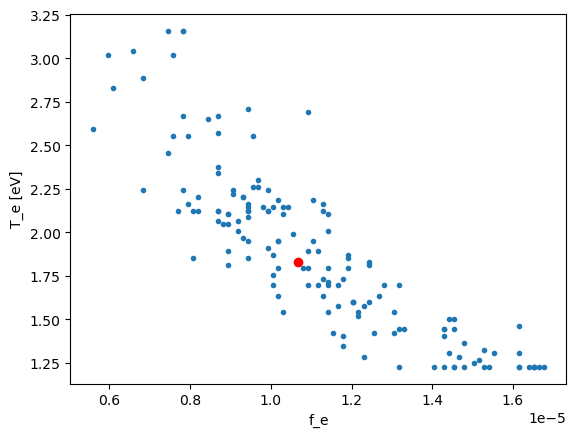

In [36]:
plt.plot( f_es[ f_e_min_idx ], T_es[ T_e_min_idx ], 'ro' )
for k in range( chisquared.shape[-1] ):
    plt.plot( f_es[  np.argmin( np.min( chisquared[:,:,k], axis = 1 ) ) ], T_es[ np.argmin( np.min( chisquared[:,:,k], axis = 0 ) ) ], '.', color='tab:blue' )


plt.xlabel("f_e")
plt.ylabel("T_e [eV]")


splt.export( filename + "_differentresults" )

./results/r003_r002_differentreps.pdf


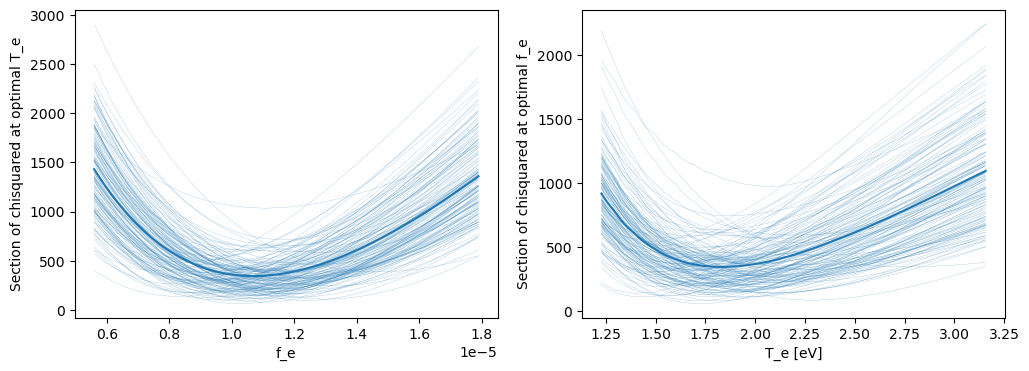

In [37]:
plt.figure( figsize = ( 12, 4 ) ).add_subplot(1, 2, 1 )


plt.plot( f_es, chisquared_avg[ :, T_e_min_idx ] )
for k in range( chisquared.shape[-1] ):
    plt.plot( f_es, chisquared[ :, T_e_min_idx, k ], lw = 0.1, alpha = 1, color = 'tab:blue' )

plt.xlabel("f_e")
plt.ylabel("Section of chisquared at optimal T_e")

ax = plt.gcf().add_subplot( 1, 2, 2 )


plt.plot( T_es, chisquared_avg[ f_e_min_idx, : ] )
for k in range( chisquared.shape[-1] ):
    plt.plot( T_es, chisquared[ f_e_min_idx, :, k ], lw = 0.1, alpha = 1, color = 'tab:blue' )

plt.xlabel("T_e [eV]")
plt.ylabel("Section of chisquared at optimal f_e")

splt.export( filename + "_differentreps" )